# Project: Vehicle Detection and Tracking
The goal of this project is to implement a pipeline to detect cars at a video stream and track them.

**Credits**: Some functions used in this project were provided by Udacity at the related lesson from the SDC ND. Many of them were tunned and updated to fit the pipeline process.

## Pipeline helper - Feature extraction
The section below presents the functions related to feature extraction from the input image. These features are fed to the previously generated model in order to predict if the current window contains or not a vehicle.

In [113]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [112]:
# Helper function for feature extraction - Perform color conversion 
# Color Space YCrCb was used for training and prediction
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Helper function for feature extraction - Extracts the HOG from the input image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper function for feature extraction - Computes image input resize
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Helper function for feature extraction - Computes the color Histogram from image input
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [69]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [70]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bboxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print(test_features.shape)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    #return draw_img, heatmap
    return bboxes

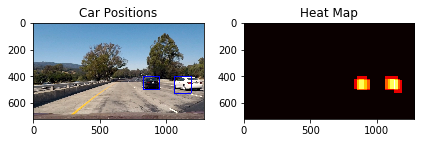

In [53]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [54]:
svc_params_dict = pickle.load( open("20-output-classifier.p", "rb" ) )

In [103]:
import collections
heatmaps = collections.deque(maxlen=3) 

In [104]:
heatmaps

deque([])

In [105]:
def pipeline1(img):
    global heatmaps
    svc = svc_params_dict["svc"]
    X_scaler = svc_params_dict["scaler"]
    orient = svc_params_dict["orient"]
    pix_per_cell = svc_params_dict["pix_per_cell"]
    cell_per_block = svc_params_dict["cell_per_block"]
    spatial_size = svc_params_dict["spatial_size"]
    hist_bins = svc_params_dict["hist_bins"]

    ystart = 400
    ystop = 656
    #scale = 1.3
    scales = [1.2, 1.6, 2]

    box_list = []
    for scale in scales:
    #out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bb = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + bb
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    
    heatmaps.append(heat)

    # Visualize the heatmap when displaying    
    heatmap = sum(heatmaps)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [76]:
def pipeline(img):
    svc = svc_params_dict["svc"]
    X_scaler = svc_params_dict["scaler"]
    orient = svc_params_dict["orient"]
    pix_per_cell = svc_params_dict["pix_per_cell"]
    cell_per_block = svc_params_dict["cell_per_block"]
    spatial_size = svc_params_dict["spatial_size"]
    hist_bins = svc_params_dict["hist_bins"]

    ystart = 400
    ystop = 656
    #scale = 1.3
    scales = [1, 1.2, 1.4, 1.6, 1.8, 2]

    box_list = []
    for scale in scales:
    #out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bb = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + bb
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

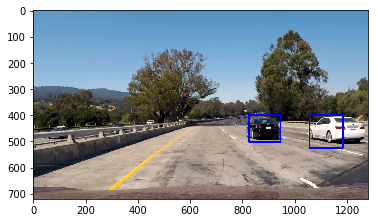

In [72]:
testImage_DIR = './11-input-testImages'
img = mpimg.imread(testImage_DIR + '/test1.jpg')

out = pipeline(img)
plt.imshow(out)
plt.show()

In [64]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

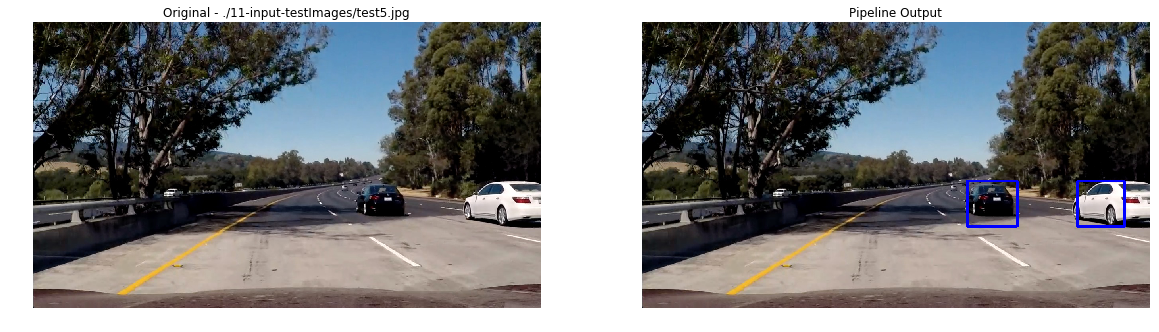

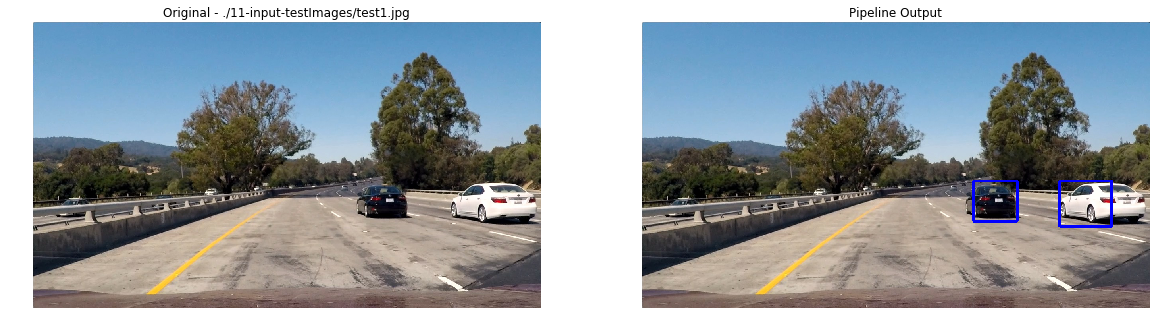

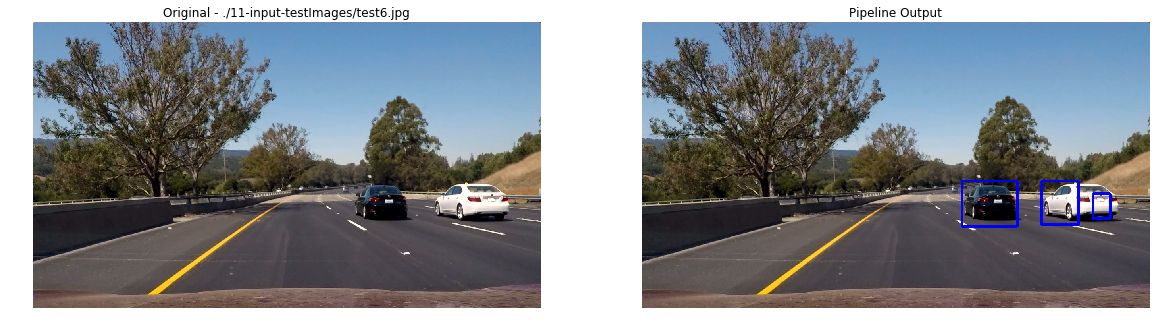

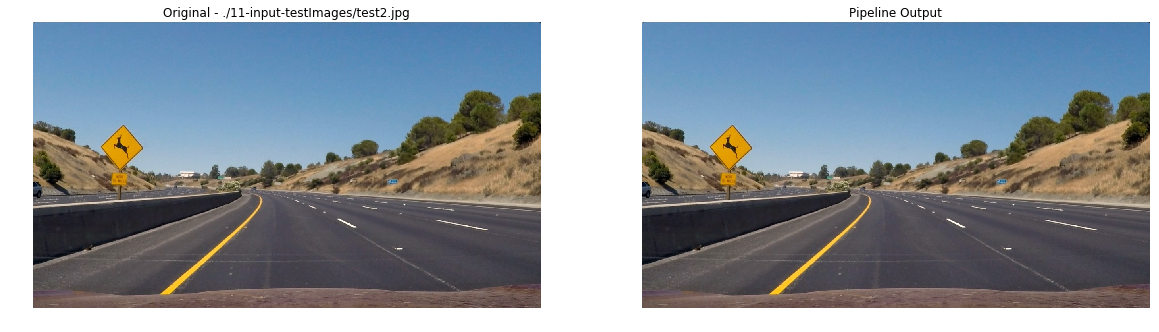

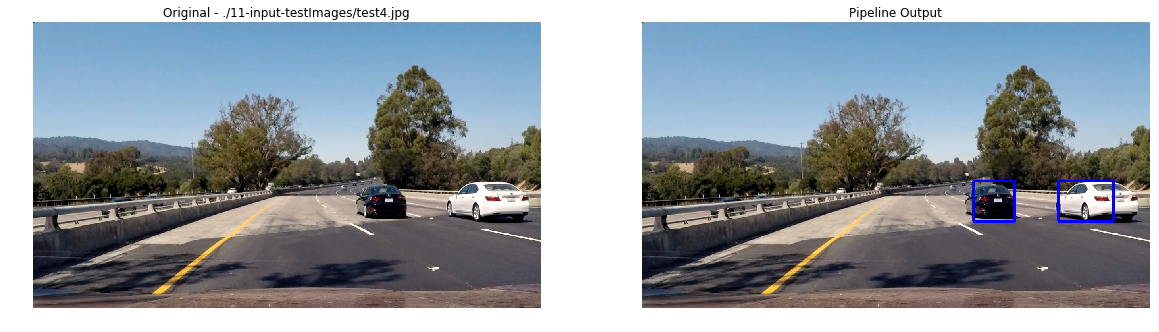

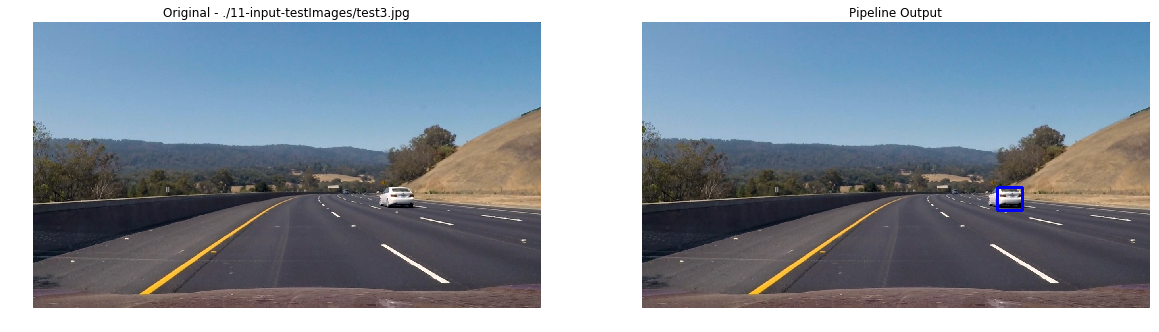

In [77]:
import glob
import os
testImage_DIR = './11-input-testImages/'
images = glob.glob(testImage_DIR + '*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    out = pipeline(img)#, False)
    file = os.path.basename(fname)
    pltCompare(img, 'Original - {}'.format(fname), out, 'Pipeline Output')

In [109]:
def process_image(image):
    return pipeline(image)

In [110]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = '20-output-projectVideo.mp4'
clip = VideoFileClip('./10-input-videos/11-input-testVideo.mp4')
video_output_clip = clip.fl_image(process_image)
%time video_output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video 20-output-projectVideo.mp4
[MoviePy] Writing video 20-output-projectVideo.mp4


 97%|█████████▋| 38/39 [02:12<00:03,  3.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: 20-output-projectVideo.mp4 

CPU times: user 2min 18s, sys: 496 ms, total: 2min 19s
Wall time: 2min 13s


In [111]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))